In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

Import audio

In [14]:
x , sr = librosa.load('../samples/chords&notes.wav')

<h2 style= "font-size:3rem;color:orange"> Delay & Echo Effect</h2>

A delay or echo effect can be represented by

$y[n] = x[n] + b_N · x[n − N]$ , with delay length $N$.

The following implementation makes use of a circular buffer

In [60]:
def Delay(x, buffer, n, delay_length_samples, decay):    

    idxR = (n - i * delay_length_samples) %  max_delay_length # Read index
    y = x + np.power(decay, i)* buffer[idxR]
      
    idxW = n % max_delay_length # write index
    buffer[idxW] = x
    
    return y, buffer

Example of a single delay line, with $N = 500$ ms, $b_N = 1$ (no decay)

In [75]:
number_of_delays = 2
delay_length = int(0.5 * sr)
max_delay_length = number_of_delays * delay_length
buffer = np.zeros([number_of_delays, max_delay_length])
delay_outputs = np.zeros(number_of_delays)
print(np.shape(buffer))

y = np.zeros(len(x) + delay_length * number_of_delays)

for n in range(0, len(x)):
    for i in range(0, number_of_delays):
        delay_outputs[i], buffer[i] = Delay(x[n], buffer[i], n, delay_length * i, 1)
    y[n] = np.sum(delay_outputs)   


(2, 22050)


In [76]:
ipd.Audio(data = y, rate = sr)

An echo can be seen as a delayed and attanuated signal. 

Comparing different decays ($b_N = 1, 0.8, 0.6$) with 5 delay lines and $N = 500$ ms

In [6]:
number_of_delays = 5
delay_length = int(0.5 * sr)
max_delay_length = number_of_delays * delay_length
buffer = np.zeros(max_delay_length)
g = [1, 0.8, 0.6]
y = np.zeros([len(x) + delay_length * number_of_delays, len(g)])


for i in range(0 , len(g)):
    for n in range(0, len(x)):
        y[n][i], buffer = Delay(x[n], buffer, n, delay_length, number_of_delays, g[i])

Plot the results

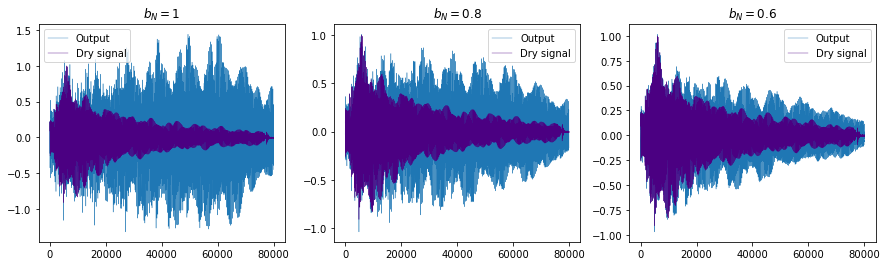

In [7]:
plot_titles = ['$b_N = 1$', '$b_N = 0.8$', '$b_N = 0.6$' ]
plt.figure(figsize = (15,4))
for i in range(0, len(g)):
    plt.subplot(1,3,i+1)
    plt.title(plot_titles[i])
    plt.plot(y[200000:280000, i], linewidth = 0.4, label=f'Output')
    plt.plot(x[200000:280000] , linewidth = 0.4, label=f'Dry signal', color='indigo')
    plt.legend()

In [8]:
ipd.Audio(data = y[:,1], rate = sr)

<h2 style="font-size:3rem;color:orange">Chorus & Flanger Effect</h2>

Both chorus and flanger effects can be recreated using a variable delay line:

$y[n] = x[n] + b_N · x[n − g[n]]$. 


Here, $g[n]$ varies over time, which can for example be a LFO used in this example. 

In [9]:
def FractionalDelay(x, buffer, n, sr, predelay, wet, depth, speed, max_delay_length):    
    #angle_change = 2 * np.pi * speed * 1 / sr
    
    LFO = depth * np.cos(2 * np.pi * speed * n / sr)
    
    idxR1 = (n - predelay - int(np.floor(LFO))) %  max_delay_length # Read index1
    idxR2 = (n - predelay - int(np.ceil(LFO))) % max_delay_length # Read index2
    
    dry = 1 - wet
    fraction = LFO - np.floor(LFO)
    y = dry * x + wet * (fraction * buffer[idxR1] + (1 - fraction) * buffer[idxR2])
      
    idxW = n % max_delay_length # write index
    buffer[idxW] = x
    
    return y, buffer

With chorus effects, the delay is typically between 10 and 25 ms:

In [10]:
wet = 0.4
predelay = int(0.01 * sr) # 10 ms predelay
depth = int(0.005 * sr) # 5 ms varying
speed = 0.6
max_delay_length = int(np.ceil(depth + predelay))
buffer = np.zeros(max_delay_length)
y = np.zeros(len(x))

for n in range(0, len(x)):
    y[n], buffer = FractionalDelay(x[n], buffer, n, sr, predelay, wet, depth, speed, max_delay_length)

In [11]:
ipd.Audio(data = y, rate = sr)

With flanger effects, the delay is typically below 10 ms:

In [12]:
wet = 0.4
predelay = int(0.003 * sr) # 3 ms predelay
depth = int(0.003 * sr) # 3 ms varying
speed = 1.2
max_delay_length = int(np.ceil(depth + predelay))
buffer = np.zeros(max_delay_length)
y = np.zeros(len(x))

for n in range(0, len(x)):
    y[n], buffer = FractionalDelay(x[n], buffer, n, sr, predelay, wet, depth, speed, max_delay_length)

In [13]:
ipd.Audio(data = y, rate = sr)